# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from sklearn.inspection import PartialDependenceDisplay



# Exploratory Data Analysis

In [116]:
# Read the parquet file

df = pd.read_parquet('Mendota_C_0.parquet', engine= 'pyarrow')
df

,source,datetime,lake_id,depth,variable,unit,observation,flag
0,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.0,temp,DEG_C,10.09,None
1,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.5,temp,DEG_C,9.19,None
2,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.0,temp,DEG_C,8.50,None
3,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.5,temp,DEG_C,8.26,None
4,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,2.0,temp,DEG_C,8.28,None
...,...,...,...,...,...,...,...,...
1499995,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,2.0,temp,DEG_C,5.25,None
1499996,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,3.0,temp,DEG_C,5.25,None
1499997,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,4.0,temp,DEG_C,5.25,None
1499998,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,5.0,temp,DEG_C,5.26,None


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   source       1500000 non-null  object        
 1   datetime     1500000 non-null  datetime64[us]
 2   lake_id      1500000 non-null  object        
 3   depth        1500000 non-null  float64       
 4   variable     1500000 non-null  object        
 5   unit         1500000 non-null  object        
 6   observation  1500000 non-null  float64       
 7   flag         84686 non-null    object        
dtypes: datetime64[us](1), float64(2), object(5)
memory usage: 91.6+ MB


checking each column data type. Especially datetime column which is correctly formatted as datetime64[us].
Otherwise, the following steps would have been followed:

`df['datetime'] = pd.to_datetime(df['datetime'], errors = 'coerce')`


# Missing Values

In [3]:
# check the number of NaN values

df.isnull().sum()

source               0
datetime             0
lake_id              0
depth                0
variable             0
unit                 0
observation          0
flag           1415314
dtype: int64

Flag column has only NaN values

In [16]:
df_NaN = df[df['flag'].isnull()]

In [17]:
df_NaN

,source,datetime,lake_id,depth,variable,unit,observation,flag
0,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.0,temp,DEG_C,10.09,None
1,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.5,temp,DEG_C,9.19,None
2,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.0,temp,DEG_C,8.50,None
3,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.5,temp,DEG_C,8.26,None
4,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,2.0,temp,DEG_C,8.28,None
...,...,...,...,...,...,...,...,...
1499995,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,2.0,temp,DEG_C,5.25,None
1499996,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,3.0,temp,DEG_C,5.25,None
1499997,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,4.0,temp,DEG_C,5.25,None
1499998,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,5.0,temp,DEG_C,5.26,None


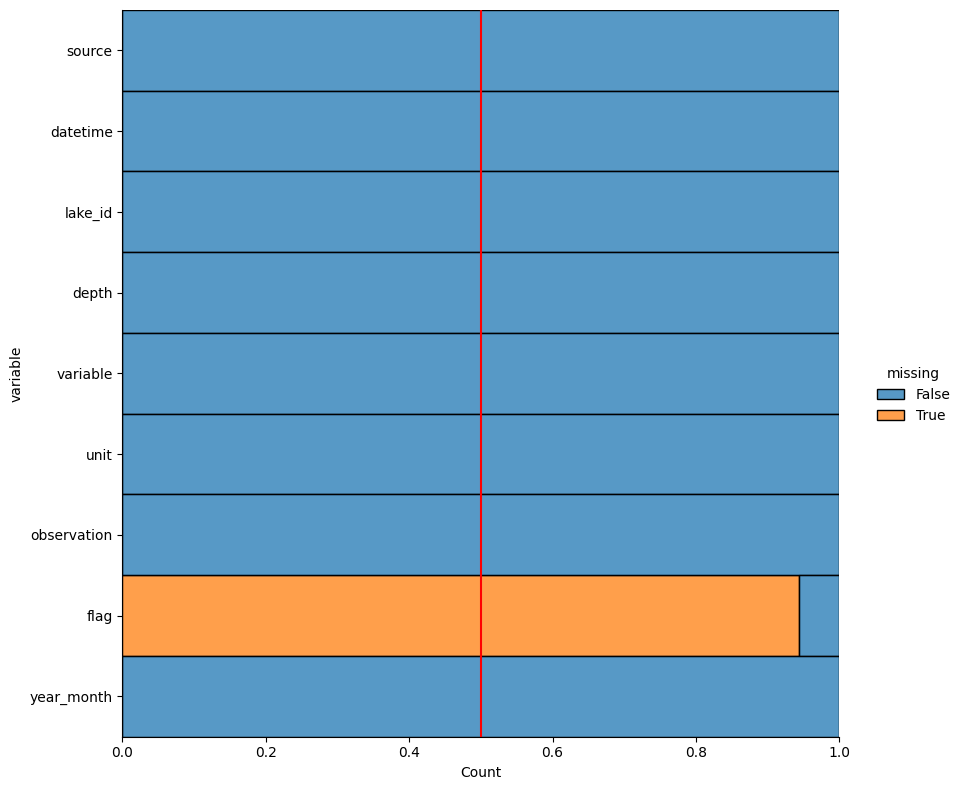

In [21]:

sns.displot(
    data=df.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
    aspect=1.1
)

# specifying a threshold value (optional)
plt.axvline(0.5, color='r')

<Axes: >

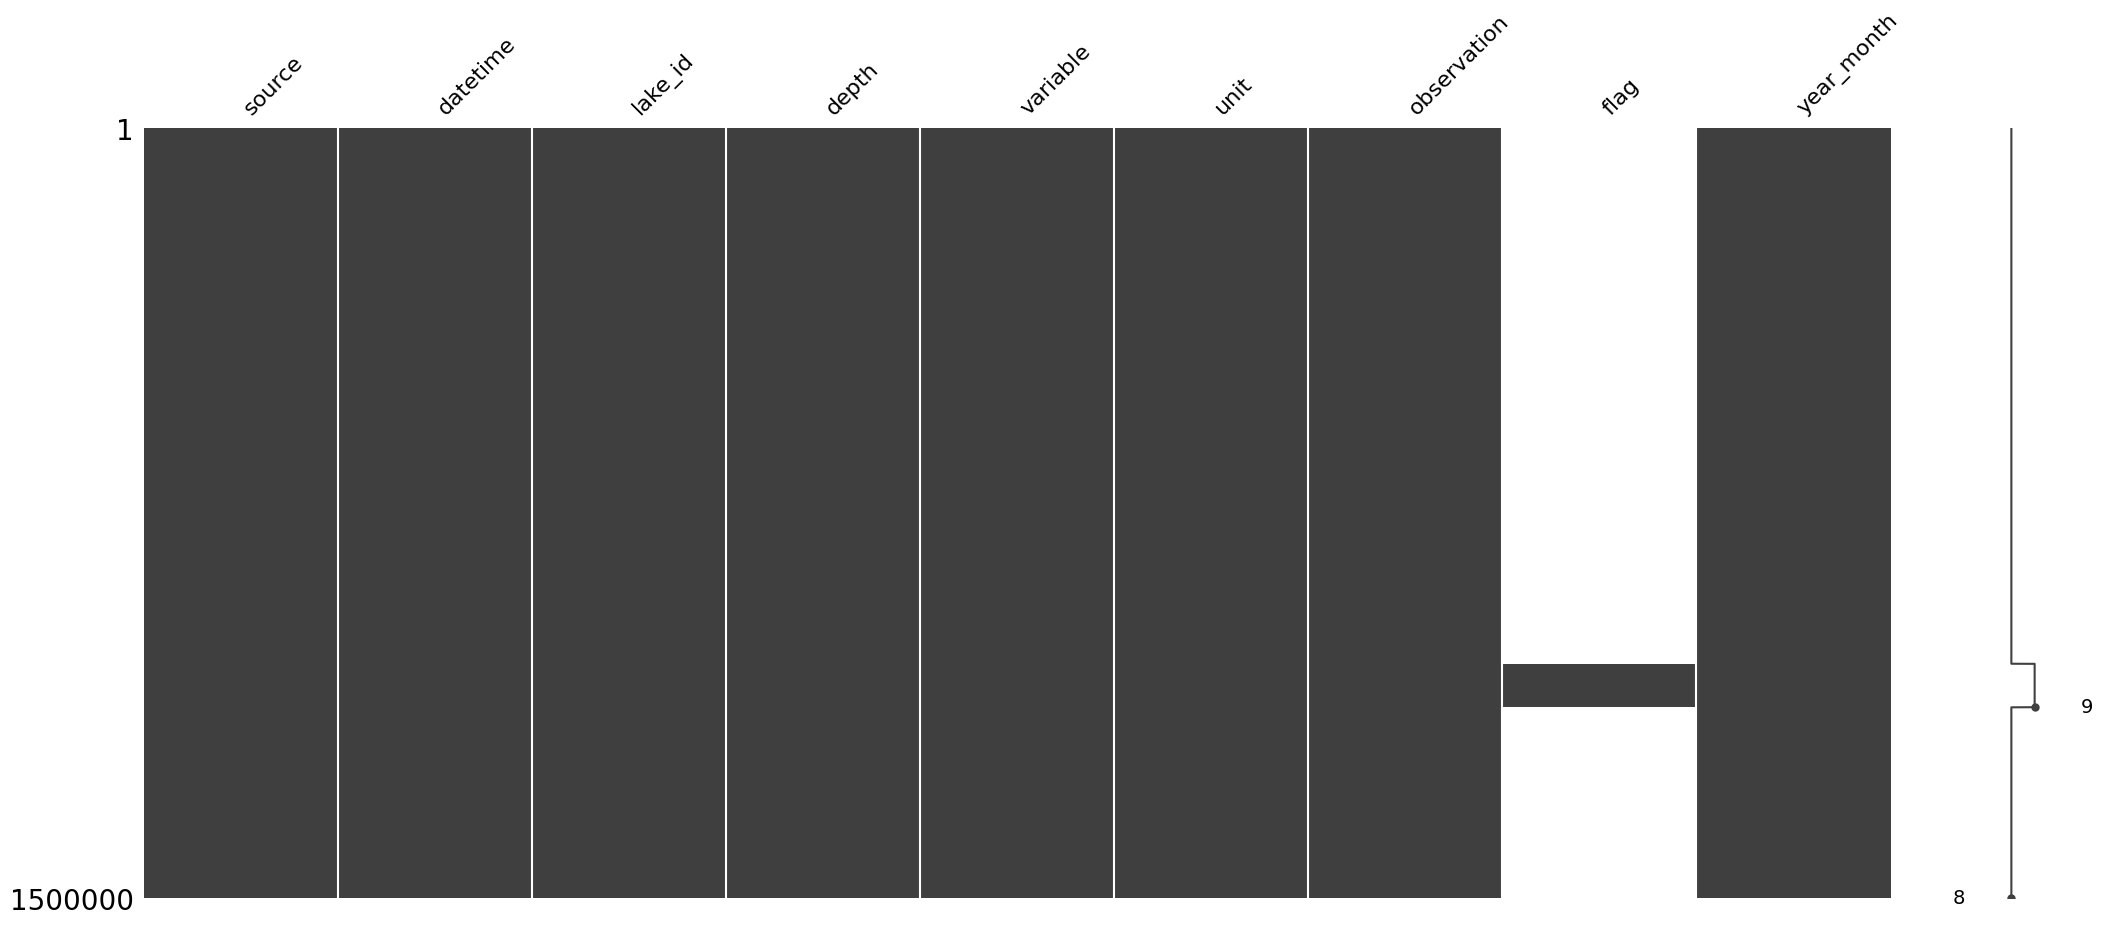

In [20]:
msno.matrix(df)

Before I do anything, it's good to assess which of the following three categories my NaN rows fall into:

**Missing Completely at Random (MCAR)**: If the probability of being missing is the same for all cases, then the data are said to be missing completely at random (MCAR),

**Missing at Random (MAR)**: If the probability of being missing is the same only within groups defined by the observed data, then the data are missing at random (MAR),

**Missing Not at Random (MNAR)**: MNAR means that the probability of being missing varies for reasons that are unknown to us.

__source: https://stefvanbuuren.name/fimd/sec-MCAR.html__



In [55]:
df["flag_missing"] = df["flag"].isna().astype(int)
df # NaN = 1, not NaN = 0

,source,datetime,lake_id,depth,variable,unit,observation,flag,flag_missing
0,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.0,temp,DEG_C,10.09,None,1
1,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.5,temp,DEG_C,9.19,None,1
2,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.0,temp,DEG_C,8.50,None,1
3,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.5,temp,DEG_C,8.26,None,1
4,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,2.0,temp,DEG_C,8.28,None,1
...,...,...,...,...,...,...,...,...,...
1499995,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,2.0,temp,DEG_C,5.25,None,1
1499996,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,3.0,temp,DEG_C,5.25,None,1
1499997,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,4.0,temp,DEG_C,5.25,None,1
1499998,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,5.0,temp,DEG_C,5.26,None,1


In [56]:
# Separate features and target
X = df.drop(columns= ['flag','flag_missing', 'source', 'lake_id', 
                      'variable', 'unit', 'datetime']) # drop non-numerical and missing values
y = df['flag_missing']

# Split data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Apply random under sampler because the classes are imbalanced 
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# shuffle the groups
X_res, y_res = shuffle(X_res, y_res, random_state=42)


print("Y Resampled class distribution:", y_res.value_counts())
print(X_train.shape, X_test.shape)
print("Train class balance before resampling:", y_train.value_counts())
print("Test class balance:", y_test.value_counts())
print("Any NaNs left in X_train?", X_train.isna().sum().sum())

# Train classifier on balanced data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_res, y_res)

# Evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Y Resampled class distribution: flag_missing
1    59280
0    59280
Name: count, dtype: int64
(1050000, 2) (450000, 2)
Train class balance before resampling: flag_missing
1    990720
0     59280
Name: count, dtype: int64
Test class balance: flag_missing
1    424594
0     25406
Name: count, dtype: int64
Any NaNs left in X_train? 0
ROC AUC: 0.9953084716119942


A ROC AUC value of 0,99 means that, the model can accurately distinguish between the positive and negative classes using depth and observations as the features. 

In [57]:
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(10))


observation    0.982325
depth          0.017675
dtype: float64


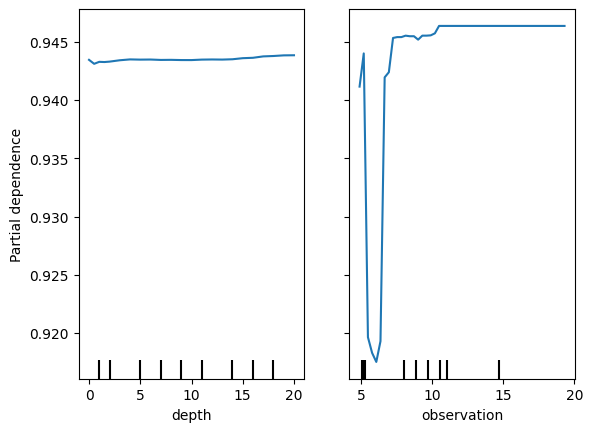

In [42]:
PartialDependenceDisplay.from_estimator(
    clf,
    X_train,
    features=['depth', 'observation'],
    kind="average",  # 'average' is standard partial dependence
    grid_resolution=50
)

plt.show()

So the model says:

observation **(~98%)** almost completely explains whether the value is missing (completely tied to the missingness).

depth **(~2%)** contributes just a little (minor effect).

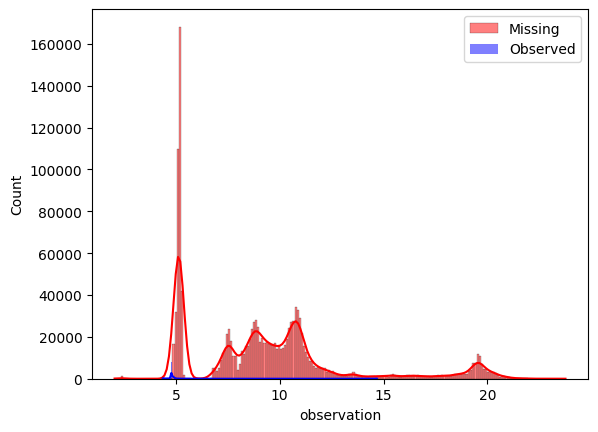

In [43]:
sns.histplot(df[df['flag_missing']==1]['observation'], color='red', label='Missing', kde=True)
sns.histplot(df[df['flag_missing']==0]['observation'], color='blue', label='Observed', kde=True)
plt.legend()
plt.show()


In [70]:
missing_rate_obs = df.groupby("observation")["flag_missing"].mean().reset_index()
missing_rate_obs['observation'].describe()


count    1835.000000
mean       13.472327
std         5.428772
min         2.050000
25%         8.855000
50%        13.440000
75%        18.025000
max        23.760000
Name: observation, dtype: float64

In [81]:
missing_rate_obs[missing_rate_obs["flag_missing"] == 0]

,observation,flag_missing
16,4.37,0.0
17,4.38,0.0
18,4.39,0.0
19,4.40,0.0
20,4.41,0.0
21,4.42,0.0
22,4.43,0.0
23,4.44,0.0
24,4.45,0.0
25,4.46,0.0


We can see that when observation is in the range 4.37–6.27, the values are present. Outside this range, the values are missing.
This implies that the missingness is `systematic and MAR`, because it depends fully on an observed variable (observation), not on the unobserved values themselves.

Since the flag only has a single observed value (8), I am not not dealing with “statistical imputation” in the usual sense — it’s more of a domain/business-rule decision:
If the flag should be 8 in that observation range, then impute 8.
If don’t, then treat missingness as informative (MAR) and keep the missingness indicator.

I take the latter, because the information is too little to impute the missing values.


# Duplicates

In [5]:
# Check for duplications

df[df.duplicated()]

,source,datetime,lake_id,depth,variable,unit,observation,flag


There are no duplicates.

# Outliers

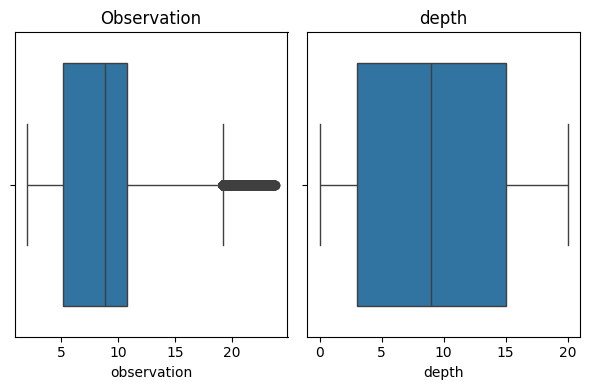

In [122]:
# Visualising the outliers in observation and depth in the whole dataset

fig, axes = plt.subplots(1, 2, figsize = (6,4))

sns.boxplot(x= df['observation'], ax = axes [0])
axes[0].set_title('Observation')

sns.boxplot(x= df['depth'], ax = axes [1])
axes[1].set_title('depth')

plt.tight_layout()
plt.show()

Depth is ranging from 0 to 20 without any outliers but observation has values higher than 20 as outliers.

In [118]:
# Extract the Year-Month period from datetime column

df['year_month'] = df['datetime'].dt.to_period('M').astype(str)

In the case of extracting only year OR only month OR only day OR only hour, the following lines are codes could be applied:

`df['year'] = df['datetime'].dt.year.astype('Int64')`

`df['month'] = df['datetime'].dt.month.astype(int)`


`df['day'] = df['datetime'].dt.day.astype(int)`


`df['hour'] = df['datetime'].dt.hour.astype(int)`



In [83]:
df

,source,datetime,lake_id,depth,variable,unit,observation,flag,flag_missing,year_month
0,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.0,temp,DEG_C,10.09,None,1,2014-05
1,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.5,temp,DEG_C,9.19,None,1,2014-05
2,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.0,temp,DEG_C,8.50,None,1,2014-05
3,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.5,temp,DEG_C,8.26,None,1,2014-05
4,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,2.0,temp,DEG_C,8.28,None,1,2014-05
...,...,...,...,...,...,...,...,...,...,...
1499995,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,2.0,temp,DEG_C,5.25,None,1,2016-04
1499996,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,3.0,temp,DEG_C,5.25,None,1,2016-04
1499997,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,4.0,temp,DEG_C,5.25,None,1,2016-04
1499998,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,5.0,temp,DEG_C,5.26,None,1,2016-04


In [85]:
# Group the data based on year and month and measure the mean, min and max values of observed temperature in these times

df_grouped_time = df.groupby('year_month')['observation'].agg(['mean','min','max', 'median'])
df_grouped_time

,mean,min,max,median
year_month,,,,
2014-05,10.081920,2.05,23.76,9.80
2014-06,14.098098,2.48,22.80,11.75
2016-03,4.802329,4.37,14.68,4.79
2016-04,5.128666,4.49,6.68,5.15


## Find the outliers in different timestamps

In [119]:
# Extract only the entries for specific duration of time

Observation201405 = df[df['year_month'] == '2014-05']
Observation201406 = df[df['year_month'] == '2014-06']
Observation201603 = df[df['year_month'] == '2016-03']
Observation201604 = df[df['year_month'] == '2016-04']

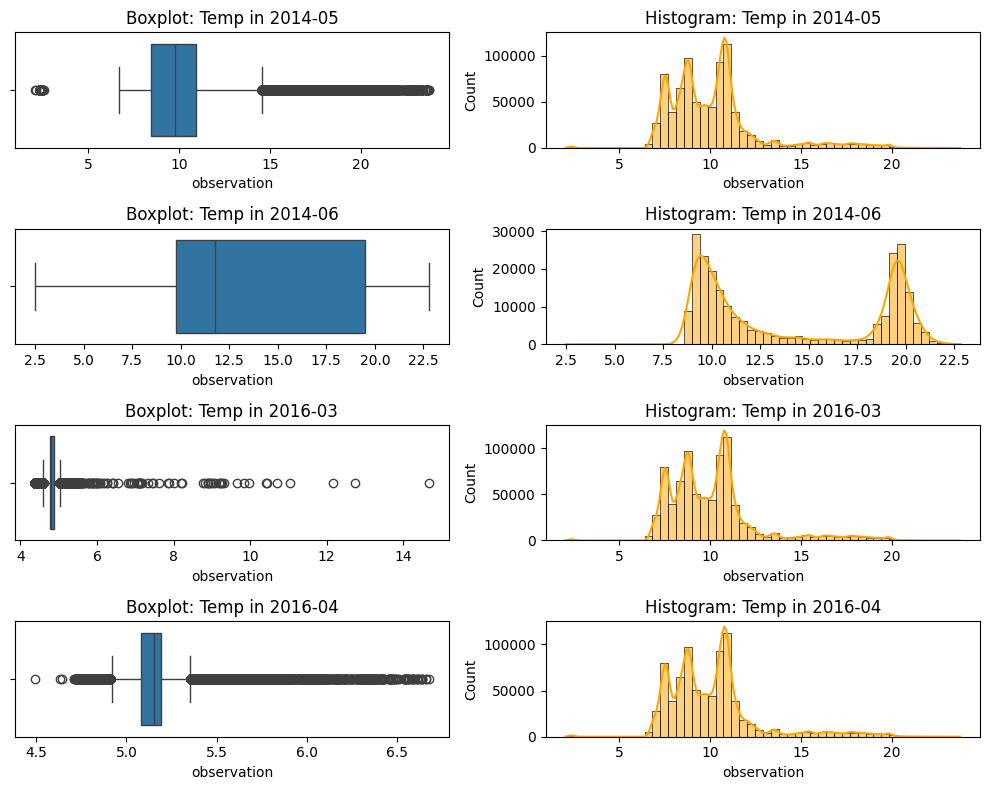

In [120]:
# Observation Histogram and Boxplot for temperature observation data before handling the outliers 

fig, axes = plt.subplots(4, 2, figsize = (10,8))

sns.boxplot(data =Observation201405, x = 'observation', ax = axes [0,0])
axes[0,0].set_title('Boxplot: Temp in 2014-05')
sns.histplot(data =Observation201405, x = 'observation', bins = 50, ax = axes [0,1], 
             kde = True, color= 'orange')
axes[0,1].set_title('Histogram: Temp in 2014-05')

sns.boxplot(data =Observation201406, x = 'observation', ax = axes [1,0])
axes[1,0].set_title('Boxplot: Temp in 2014-06')
sns.histplot(data =Observation201406, x = 'observation', bins = 50, ax = axes [1,1], 
             kde = True, color= 'orange')
axes[1,1].set_title('Histogram: Temp in 2014-06')

sns.boxplot(data =Observation201603, x = 'observation', ax = axes [2,0])
axes[2,0].set_title('Boxplot: Temp in 2016-03')
sns.histplot(data =Observation201405, x = 'observation', bins = 50, ax = axes [2,1], 
             kde = True, color= 'orange')
axes[2,1].set_title('Histogram: Temp in 2016-03')

sns.boxplot(data =Observation201604, x = 'observation', ax = axes [3,0])
axes[3,0].set_title('Boxplot: Temp in 2016-04')
sns.histplot(data =Observation201405, x = 'observation', bins = 50, ax = axes [3,1], 
             kde = True, color= 'orange')
axes[3,1].set_title('Histogram: Temp in 2016-04')

plt.tight_layout()
plt.show()

**2014-05 & 2014-06:**

The distributions are fairly wide, with long tails. Boxplots show some extreme points, but they are not heavily distorting the overall shape. The histograms are multi-modal but still interpretable.

**2016-03 & 2016-04:**

The boxplots show many outliers, especially in 2016-03. However, the histograms suggest these are not necessarily errors but part of a skewed/multi-modal distribution.

So, while there are “outliers” by boxplot definition, they may reflect natural variability rather than noise.
However, due to the sake of practice and exercise, I will handle the outliers by _machine learning imputation_ methods and _winsorization_.

In [11]:
df.describe()

,datetime,depth,observation
count,1500000,1.500000e+06,1.500000e+06
mean,2014-12-17 04:05:18.438680,9.290328e+00,9.187778e+00
min,2014-05-05 00:00:00,0.000000e+00,2.050000e+00
25%,2014-05-16 10:46:00,3.000000e+00,5.200000e+00
50%,2014-05-27 20:50:00,9.000000e+00,8.880000e+00
75%,2016-04-01 02:26:00,1.500000e+01,1.080000e+01
max,2016-04-12 10:10:00,2.000000e+01,2.376000e+01
std,NaN,6.290739e+00,3.996815e+00


In [121]:
def OutliersByDate (dataset):
    Q1 = dataset['observation'].quantile(0.25)
    Q3 = dataset['observation'].quantile(0.75)

    # Calculate the interquartile range
    IQR = Q3 - Q1

     # Define the lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR # Whisker 1
    upper_bound = Q3 + 1.5 * IQR # Whisker 2

    outliers = dataset[(dataset['observation'] < lower_bound) | (dataset['observation'] > upper_bound)]
    print(f"Number of outliers: {outliers.shape[0]} in {dataset['year_month'].unique()[0]}")
    return outliers



In [122]:
Outliers201405 = OutliersByDate(Observation201405)
Outliers201406 = OutliersByDate(Observation201406)
Outliers201603 = OutliersByDate(Observation201603)
Outliers201604 = OutliersByDate(Observation201604)

Number of outliers: 53904 in 2014-05
Number of outliers: 0 in 2014-06
Number of outliers: 10896 in 2016-03
Number of outliers: 21585 in 2016-04


## Which depth range is more frequent in different timestamps' outliers?

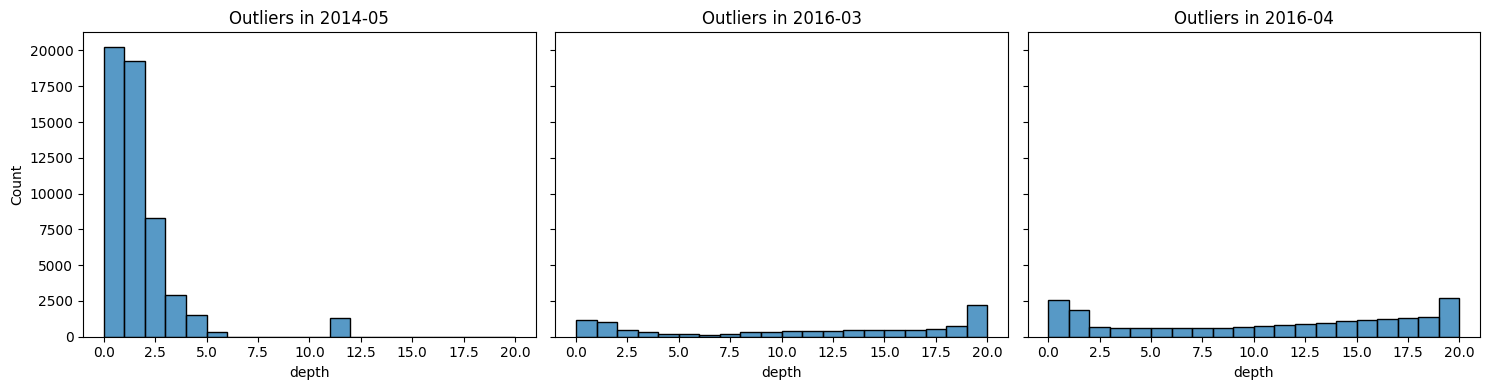

In [30]:
# Outliers in a list and their titles
outliers_list = [Outliers201405, Outliers201603, Outliers201604]
titles = ["Outliers in 2014-05", "Outliers in 2016-03", "Outliers in 2016-04"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Loop through datasets and axes
for ax, outliers, title in zip(axes, outliers_list, titles):
    sns.histplot(data=outliers, x="depth", stat="count", bins=20, ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

For the 2014/05 timestamp, the outliers are frequently occured in the depth ranges of 0 to 6 meters. However, in 2016 March and April, the trend of outliers in different depths in similar and almost evenly distributed across different depths. 

## Is there a correlation between `observation` and `depth` columns?

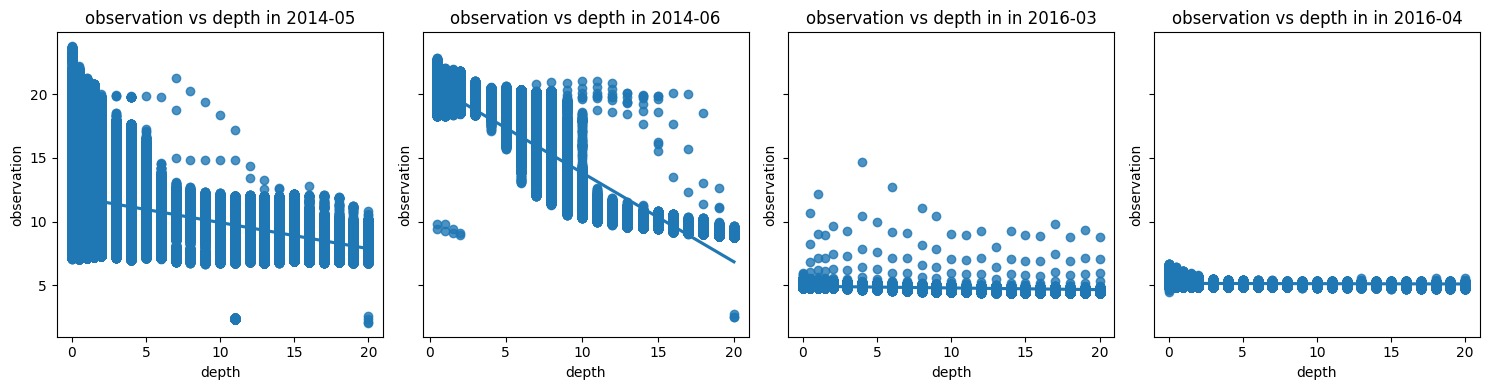

In [93]:
# Observations in a list and their titles
observation_list = [Observation201405, Observation201406, Observation201603, Observation201604]
titles = ["observation vs depth in 2014-05", "observation vs depth in 2014-06","observation vs depth in in 2016-03", "observation vs depth in in 2016-04"]

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

# Loop through datasets and axes
for ax, obs, title in zip(axes, observation_list, titles):
    sns.regplot(data=obs, x="depth", y="observation", ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In the 2016 timestamp, it is observable that there is no correlation between `depth` and `observation` values, since the trend line is a straight line. so, to handle outliers for these timestamps I use `winsorization`. Therefore, we cannot use `IterativeImputer` method to predict the correct outliers in the `observation` column using `depth` column. In another word, if depth has no correlation with observation, the imputer will basically have no useful information to predict the missing/outlier values.

## Handling outliers by `Winsorization` 

For temperature in March and April of 2016 because there is no correlation between _temperature observations_ and _depth_ or any other variables.

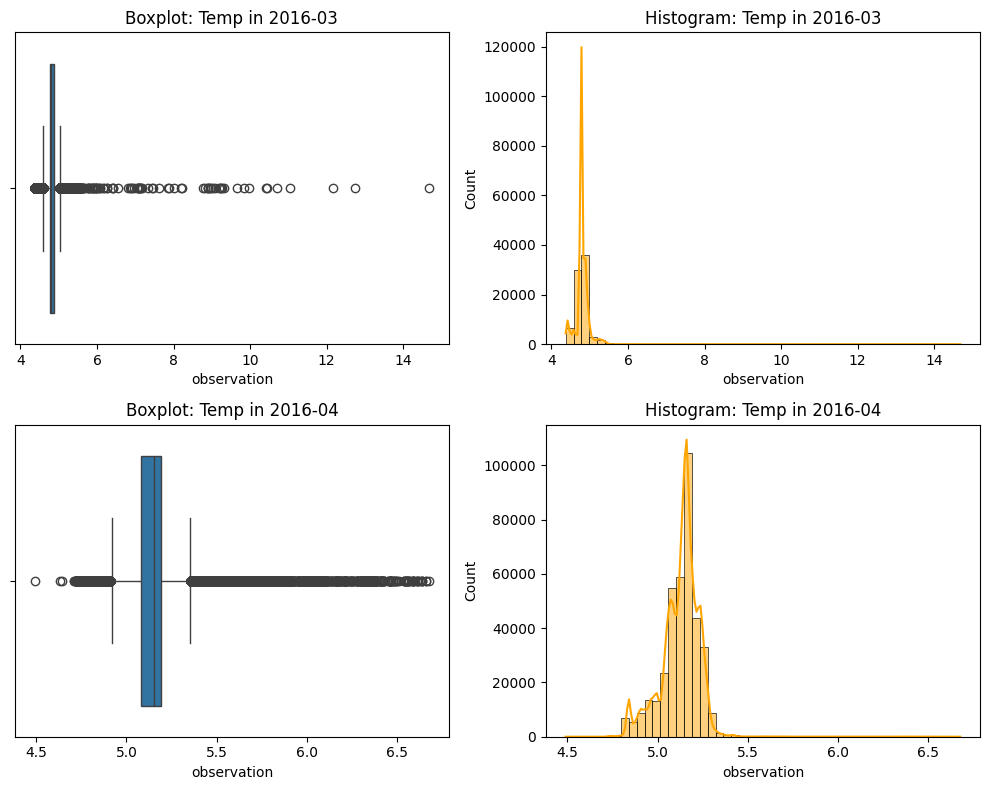

In [123]:
# Compute boundaries: 2016/03
lower201603 = Observation201603['observation'].quantile(0.05)
upper201603 = Observation201603['observation'].quantile(0.95)

# Compute boundaries: 2016/04
lower201604 = Observation201604['observation'].quantile(0.05)
upper201604 = Observation201604['observation'].quantile(0.95)

# Apply winsorization: 2016/03
winsorized201603 = Observation201603['observation'].clip(lower201603, upper201603)

# Apply winsorization: 2016/04
winsorized201604 = Observation201604['observation'].clip(lower201604, upper201604)

# ------------

# Visualise temperature data after applying winsorization 
fig, axes = plt.subplots(2, 2, figsize = (10,8))

# Time: 2016/03
sns.boxplot(data =Observation201603, x = 'observation', ax = axes [0,0])
axes[0,0].set_title('Boxplot: Temp in 2016-03')
sns.histplot(data =Observation201603, x = 'observation', bins = 50, ax = axes [0,1], 
             kde = True, color= 'orange')
axes[0,1].set_title('Histogram: Temp in 2016-03')

# Time: 2016/03
sns.boxplot(data =Observation201604, x = 'observation', ax = axes [1,0])
axes[1,0].set_title('Boxplot: Temp in 2016-04')
sns.histplot(data =Observation201604, x = 'observation', bins = 50, ax = axes [1,1], 
             kde = True, color= 'orange')
axes[1,1].set_title('Histogram: Temp in 2016-04')

plt.tight_layout()
plt.show()


## Handling outliers by `IterativeImputer`

For May of 2014 because there is a negative correlation between _temperature observation_ and _depth_, so we can use the Iterativeimputer method.

In [124]:
# Step 1: replace the outliers with NaN values

Observation201405['outliers_flagged_nan'] = Observation201405['observation'].where(
                                            ~Observation201405.index.isin(Outliers201405.index), np.nan)

Observation201405

/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_61616/1083638725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Observation201405['outliers_flagged_nan'] = Observation201405['observation'].where(


,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,outliers_flagged_nan
0,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.0,temp,DEG_C,10.09,None,2014-05,10.09
1,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.5,temp,DEG_C,9.19,None,2014-05,9.19
2,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.0,temp,DEG_C,8.50,None,2014-05,8.50
3,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.5,temp,DEG_C,8.26,None,2014-05,8.26
4,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,2.0,temp,DEG_C,8.28,None,2014-05,8.28
...,...,...,...,...,...,...,...,...,...,...
808907,EDI knb-lter-ntl.130.33,2014-05-29 16:00:00,ME,16.0,temp,DEG_C,9.45,None,2014-05,9.45
808908,EDI knb-lter-ntl.130.33,2014-05-29 16:00:00,ME,17.0,temp,DEG_C,9.39,None,2014-05,9.39
808909,EDI knb-lter-ntl.130.33,2014-05-29 16:00:00,ME,18.0,temp,DEG_C,9.18,None,2014-05,9.18
808910,EDI knb-lter-ntl.130.33,2014-05-29 16:00:00,ME,19.0,temp,DEG_C,8.94,None,2014-05,8.94


In [125]:
# The number of outliers which are replaced to NaN 
Observation201405['outliers_flagged_nan'].isnull().sum()

53904

In [56]:
# The information of the Observation201405 dataset
Observation201405.info()

<class 'pandas.core.frame.DataFrame'>
Index: 808912 entries, 0 to 808911
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   source                808912 non-null  object        
 1   datetime              808912 non-null  datetime64[us]
 2   lake_id               808912 non-null  object        
 3   depth                 808912 non-null  float64       
 4   variable              808912 non-null  object        
 5   unit                  808912 non-null  object        
 6   observation           808912 non-null  float64       
 7   flag                  0 non-null       object        
 8   year_month            808912 non-null  object        
 9   outliers_flagged_nan  755008 non-null  float64       
dtypes: datetime64[us](1), float64(3), object(6)
memory usage: 67.9+ MB


In [126]:
#Step 2: impute outliers for the Observation201405 dataset in the timestamp 2014/05

features = ['outliers_flagged_nan', 'depth']  # there is a correlation between depth and temperature

imputer = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)

X_imputed = imputer.fit_transform(Observation201405[features])

Observation201405['outliersImputed'] = X_imputed[:, 0]  # save back to the dataframe

/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_61616/3465835520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Observation201405['outliersImputed'] = X_imputed[:, 0]  # save back to the dataframe


In [169]:
X_imputed

array([[10.09,  0.  ],
       [ 9.19,  0.5 ],
       [ 8.5 ,  1.  ],
       ...,
       [ 5.25,  4.  ],
       [ 5.26,  5.  ],
       [ 5.26,  6.  ]])

In [61]:
# Visually inspect the differece in values in before and after imputation 
Observation201405[Observation201405['outliers_flagged_nan'].isnull()]

,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,outliers_flagged_nan,outliersImputed
152578,EDI knb-lter-ntl.130.33,2014-05-09 17:35:00,ME,20.0,temp,DEG_C,2.10,None,2014-05,NaN,8.152330
221119,EDI knb-lter-ntl.130.33,2014-05-11 19:16:00,ME,0.0,temp,DEG_C,14.66,None,2014-05,NaN,10.262537
221142,EDI knb-lter-ntl.130.33,2014-05-11 19:17:00,ME,0.0,temp,DEG_C,14.72,None,2014-05,NaN,10.262537
221165,EDI knb-lter-ntl.130.33,2014-05-11 19:18:00,ME,0.0,temp,DEG_C,14.77,None,2014-05,NaN,10.262537
221188,EDI knb-lter-ntl.130.33,2014-05-11 19:19:00,ME,0.0,temp,DEG_C,14.78,None,2014-05,NaN,10.262537
...,...,...,...,...,...,...,...,...,...,...,...
808891,EDI knb-lter-ntl.130.33,2014-05-29 16:00:00,ME,1.0,temp,DEG_C,18.32,None,2014-05,NaN,10.184270
808892,EDI knb-lter-ntl.130.33,2014-05-29 16:00:00,ME,1.5,temp,DEG_C,18.31,None,2014-05,NaN,10.245324
808893,EDI knb-lter-ntl.130.33,2014-05-29 16:00:00,ME,2.0,temp,DEG_C,18.26,None,2014-05,NaN,10.414956
808894,EDI knb-lter-ntl.130.33,2014-05-29 16:00:00,ME,3.0,temp,DEG_C,17.98,None,2014-05,NaN,10.690331


In [59]:
Observation201405.describe()

,datetime,depth,observation,outliers_flagged_nan,outliersImputed
count,808912,808912.000000,808912.000000,755008.000000,808912.000000
mean,2014-05-17 07:53:02.266599,9.231050,10.081920,9.597333,9.642217
min,2014-05-05 00:00:00,0.000000,2.050000,6.690000,6.690000
25%,2014-05-11 05:34:00,3.000000,8.480000,8.410000,8.490000
50%,2014-05-17 08:07:00,9.000000,9.800000,9.570000,9.800000
75%,2014-05-23 10:40:00,15.000000,10.920000,10.800000,10.750000
max,2014-05-29 16:00:00,20.000000,23.760000,14.570000,14.570000
std,NaN,6.314408,2.458952,1.548450,1.505970


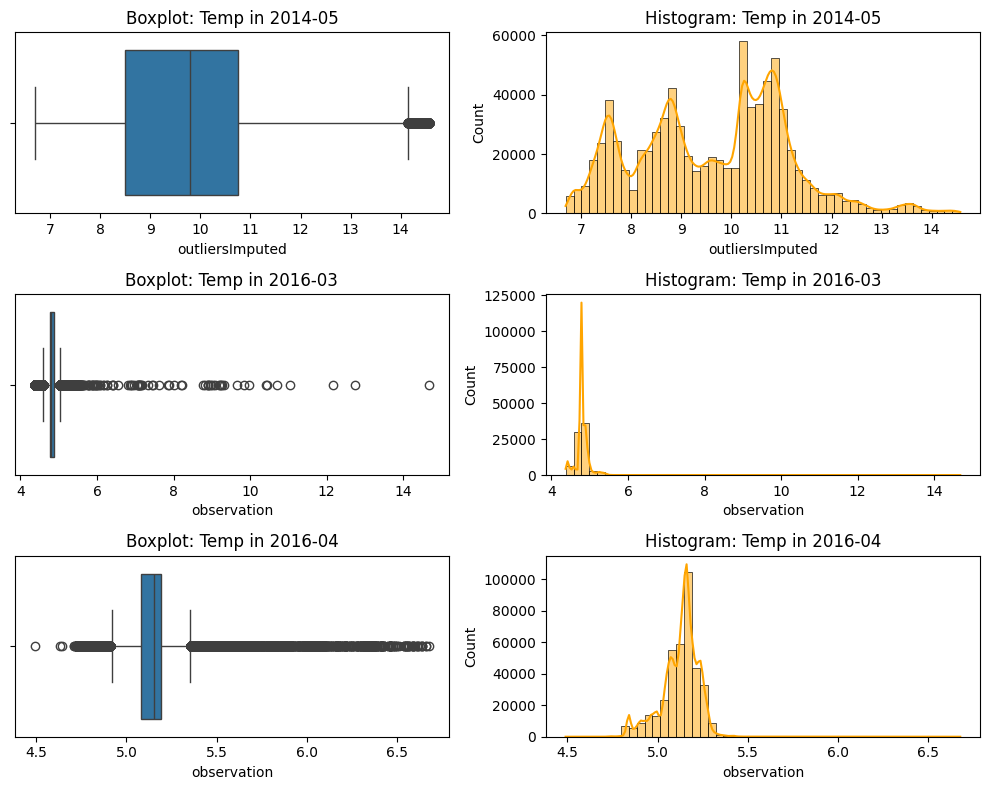

In [128]:
# Observation Histogram and Boxplot for temperature observation data before handling the outliers 

fig, axes = plt.subplots(3, 2, figsize = (10,8))

sns.boxplot(data =Observation201405, x = 'outliersImputed', ax = axes [0,0])
axes[0,0].set_title('Boxplot: Temp in 2014-05')
sns.histplot(data =Observation201405, x = 'outliersImputed', bins = 50, ax = axes [0,1], 
             kde = True, color= 'orange')
axes[0,1].set_title('Histogram: Temp in 2014-05')

sns.boxplot(data =Observation201603, x = 'observation', ax = axes [1,0])
axes[1,0].set_title('Boxplot: Temp in 2016-03')
sns.histplot(data =Observation201603, x = 'observation', bins = 50, ax = axes [1,1], 
             kde = True, color= 'orange')
axes[1,1].set_title('Histogram: Temp in 2016-03')

sns.boxplot(data =Observation201604, x = 'observation', ax = axes [2,0])
axes[2,0].set_title('Boxplot: Temp in 2016-04')
sns.histplot(data =Observation201604, x = 'observation', bins = 50, ax = axes [2,1], 
             kde = True, color= 'orange')
axes[2,1].set_title('Histogram: Temp in 2016-04')

plt.tight_layout()
plt.show()

## Handling outliers in a bimodel

The temperature observation in Jun 2014 is a bimodel and the classical methods like winsorization or statistical imputation will not work straight away on such models.

<Axes: xlabel='observation', ylabel='Count'>

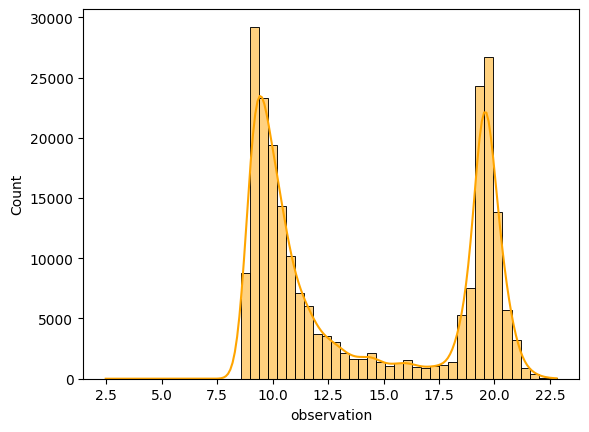

In [129]:
# Handling outliers in Observation201406 dataset for the 2014/06 timestamp. The model is Bimodel

sns.histplot(data =Observation201406, x = 'observation', bins = 50, 
             kde = True, color= 'orange')


### Handling By KMeans clustering and IterativeImputer

/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_61616/539397985.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Observation201406['bimodel_subgroup'] = labels


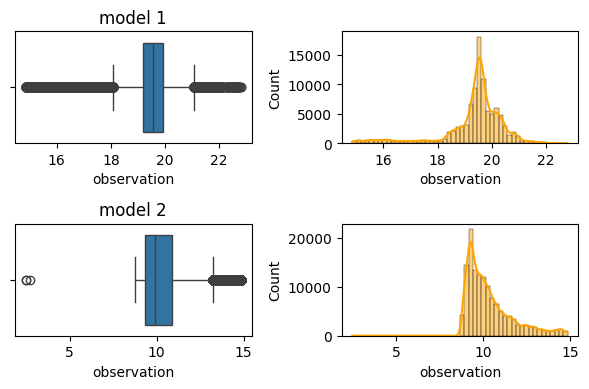

In [129]:
# Step 1: cluster the data points in two groups due to bimodelarity and each model will be treated seperately, 
# independant of the other peak

# Data 
X = Observation201406['observation'].values.reshape(-1, 1)

# Fit the model
kmeans = KMeans(n_clusters=2, random_state=42) # number of clusters = 2 because we see two peeks/models
labels = kmeans.fit_predict(X)

# Add the labels
Observation201406['bimodel_subgroup'] = labels

# Seperate the peeks into two models based on the labels
Observation201406_model1 = Observation201406[Observation201406['bimodel_subgroup'] == 0]
Observation201406_model2 = Observation201406[Observation201406['bimodel_subgroup'] == 1]

# ----------

# Visualise each model as model 1 and model 2
fig, axes = plt.subplots(2, 2, figsize = (6,4))

sns.boxplot(data =Observation201406_model1, x = 'observation', ax = axes [0,0])
sns.histplot(data =Observation201406_model1, x = 'observation', bins = 50, 
             kde = True, color= 'orange', ax = axes[0,1])
axes[0,0].set_title('model 1')

sns.boxplot(data =Observation201406_model2, x = 'observation', ax = axes [1,0])
sns.histplot(data =Observation201406_model2, x = 'observation', bins = 50, 
             kde = True, color= 'orange', ax = axes[1,1])
axes[1,0].set_title('model 2')

plt.tight_layout()
plt.show()

In [84]:
Observation201406_model1

,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,bimodel_subgroup,outliersNaN
808912,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,0.5,temp,DEG_C,21.40,None,2014-06,0,NaN
808913,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,1.0,temp,DEG_C,20.85,None,2014-06,0,20.85
808914,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,1.5,temp,DEG_C,20.68,None,2014-06,0,20.68
808915,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,2.0,temp,DEG_C,20.61,None,2014-06,0,20.61
808916,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,3.0,temp,DEG_C,20.22,None,2014-06,0,20.22
...,...,...,...,...,...,...,...,...,...,...,...
1043838,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,4.0,temp,DEG_C,20.41,None,2014-06,0,20.41
1043839,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,5.0,temp,DEG_C,19.55,None,2014-06,0,19.55
1043840,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,6.0,temp,DEG_C,18.85,None,2014-06,0,18.85
1043841,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,7.0,temp,DEG_C,17.10,None,2014-06,0,NaN


In [130]:
# step 2: find the outliers in model 1

# model 1
# Calculate the first (Q1) and third (Q3) quartiles
Q1Observation201406_model1 = Observation201406_model1['observation'].quantile(0.25)
Q3Observation201406_model1 = Observation201406_model1['observation'].quantile(0.75)

# Calculate the interquartile range
IQRObservation201406_model1 = Q3Observation201406_model1 - Q1Observation201406_model1

# Define the lower and upper bounds for outlier detection
lower_boundObservation201406_model1 = Q1Observation201406_model1 - 1.5 * IQRObservation201406_model1 # Whisker 1
upper_boundObservation201406_model1 = Q3Observation201406_model1 + 1.5 * IQRObservation201406_model1 # Whisker 2


Observation201406_model1['outliersNaN'] = np.where((Observation201406_model1['observation'] < lower_boundObservation201406_model1) | 
                                                   (Observation201406_model1['observation'] > upper_boundObservation201406_model1), 
                                                   np.nan, Observation201406_model1['observation'])
Observation201406_model1



/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_61616/2911372911.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Observation201406_model1['outliersNaN'] = np.where((Observation201406_model1['observation'] < lower_boundObservation201406_model1) |


,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,bimodel_subgroup,outliersNaN
808912,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,0.5,temp,DEG_C,21.40,None,2014-06,0,NaN
808913,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,1.0,temp,DEG_C,20.85,None,2014-06,0,20.85
808914,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,1.5,temp,DEG_C,20.68,None,2014-06,0,20.68
808915,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,2.0,temp,DEG_C,20.61,None,2014-06,0,20.61
808916,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,3.0,temp,DEG_C,20.22,None,2014-06,0,20.22
...,...,...,...,...,...,...,...,...,...,...,...
1043838,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,4.0,temp,DEG_C,20.41,None,2014-06,0,20.41
1043839,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,5.0,temp,DEG_C,19.55,None,2014-06,0,19.55
1043840,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,6.0,temp,DEG_C,18.85,None,2014-06,0,18.85
1043841,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,7.0,temp,DEG_C,17.10,None,2014-06,0,NaN


In [131]:
# step 2: find the outliers in model 2

# model 2
# Calculate the first (Q1) and third (Q3) quartiles
Q1Observation201406_model2 = Observation201406_model2['observation'].quantile(0.25)
Q3Observation201406_model2 = Observation201406_model2['observation'].quantile(0.75)

# Calculate the interquartile range
IQRObservation201406_model2 = Q3Observation201406_model2 - Q1Observation201406_model2

 # Define the lower and upper bounds for outlier detection
lower_boundObservation201406_model2 = Q1Observation201406_model2 - 1.5 * IQRObservation201406_model2 # Whisker 1
upper_boundObservation201406_model2 = Q3Observation201406_model2 + 1.5 * IQRObservation201406_model2 # Whisker 2


Observation201406_model2['outliersNaN'] = np.where((Observation201406_model2['observation'] < lower_boundObservation201406_model2) | 
                                                   (Observation201406_model2['observation'] > upper_boundObservation201406_model2), 
                                                   np.nan, Observation201406_model2['observation'])
Observation201406_model2

/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_61616/1501601537.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Observation201406_model2['outliersNaN'] = np.where((Observation201406_model2['observation'] < lower_boundObservation201406_model2) |


,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,bimodel_subgroup,outliersNaN
808920,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,7.0,temp,DEG_C,13.54,None,2014-06,1,NaN
808921,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,8.0,temp,DEG_C,12.82,None,2014-06,1,12.82
808922,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,9.0,temp,DEG_C,12.36,None,2014-06,1,12.36
808923,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,10.0,temp,DEG_C,11.87,None,2014-06,1,11.87
808924,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,11.0,temp,DEG_C,10.92,None,2014-06,1,10.92
...,...,...,...,...,...,...,...,...,...,...,...
1043850,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,16.0,temp,DEG_C,9.39,None,2014-06,1,9.39
1043851,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,17.0,temp,DEG_C,9.34,None,2014-06,1,9.34
1043852,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,18.0,temp,DEG_C,9.21,None,2014-06,1,9.21
1043853,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,19.0,temp,DEG_C,9.02,None,2014-06,1,9.02


In [132]:
# Step 3: run the IterativeImputer on each model from the bimodel

features = ['outliersNaN', 'depth']  # features

# Group 1
imputer1 = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)
X_imputed1 = imputer1.fit_transform(Observation201406_model1[features])
Observation201406_model1['outliersImputed'] = X_imputed1[:, 0]  # first column is observation

# Group 2
imputer2 = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)
X_imputed2 = imputer2.fit_transform(Observation201406_model2[features])
Observation201406_model2['outliersImputed'] = X_imputed2[:, 0]


/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_61616/3196931282.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Observation201406_model1['outliersImputed'] = X_imputed1[:, 0]  # first column is observation
/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_61616/3196931282.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Observation201406_model2['outliersImputed'] = X_imputed2[:, 0]


In [105]:
Observation201406_model1

,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,bimodel_subgroup,outliersNaN,outliersImputed
808912,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,0.5,temp,DEG_C,21.40,None,2014-06,0,NaN,19.697458
808913,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,1.0,temp,DEG_C,20.85,None,2014-06,0,20.85,20.850000
808914,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,1.5,temp,DEG_C,20.68,None,2014-06,0,20.68,20.680000
808915,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,2.0,temp,DEG_C,20.61,None,2014-06,0,20.61,20.610000
808916,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,3.0,temp,DEG_C,20.22,None,2014-06,0,20.22,20.220000
...,...,...,...,...,...,...,...,...,...,...,...,...
1043838,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,4.0,temp,DEG_C,20.41,None,2014-06,0,20.41,20.410000
1043839,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,5.0,temp,DEG_C,19.55,None,2014-06,0,19.55,19.550000
1043840,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,6.0,temp,DEG_C,18.85,None,2014-06,0,18.85,18.850000
1043841,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,7.0,temp,DEG_C,17.10,None,2014-06,0,NaN,19.170826


In [106]:
Observation201406_model2

,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,bimodel_subgroup,outliersNaN,outliersImputed
808920,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,7.0,temp,DEG_C,13.54,None,2014-06,1,NaN,12.816396
808921,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,8.0,temp,DEG_C,12.82,None,2014-06,1,12.82,12.820000
808922,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,9.0,temp,DEG_C,12.36,None,2014-06,1,12.36,12.360000
808923,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,10.0,temp,DEG_C,11.87,None,2014-06,1,11.87,11.870000
808924,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,11.0,temp,DEG_C,10.92,None,2014-06,1,10.92,10.920000
...,...,...,...,...,...,...,...,...,...,...,...,...
1043850,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,16.0,temp,DEG_C,9.39,None,2014-06,1,9.39,9.390000
1043851,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,17.0,temp,DEG_C,9.34,None,2014-06,1,9.34,9.340000
1043852,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,18.0,temp,DEG_C,9.21,None,2014-06,1,9.21,9.210000
1043853,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,19.0,temp,DEG_C,9.02,None,2014-06,1,9.02,9.020000


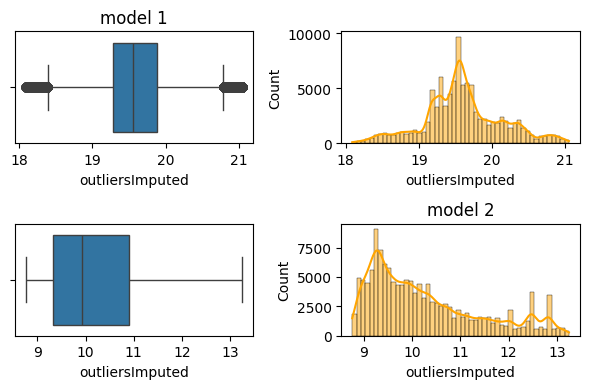

In [133]:
# visualise each model after handling outliers

fig, axes = plt.subplots(2, 2, figsize = (6,4))

sns.boxplot(data =Observation201406_model1, x = 'outliersImputed', ax = axes [0,0])
sns.histplot(data =Observation201406_model1, x = 'outliersImputed', bins = 50, 
             kde = True, color= 'orange', ax = axes[0,1])
axes[0,0].set_title('model 1')

sns.boxplot(data =Observation201406_model2, x = 'outliersImputed', ax = axes [1,0])
sns.histplot(data =Observation201406_model2, x = 'outliersImputed', bins = 50, 
             kde = True, color= 'orange', ax = axes[1,1])
axes[1,1].set_title('model 2')

plt.tight_layout()


In [134]:
# Step 4 (optional): concatenate two models to re-create the dataset 

Observation201406Imputed = pd.concat([Observation201406_model1, Observation201406_model2])
Observation201406Imputed

,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,bimodel_subgroup,outliersNaN,outliersImputed
808912,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,0.5,temp,DEG_C,21.40,None,2014-06,0,NaN,19.697918
808913,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,1.0,temp,DEG_C,20.85,None,2014-06,0,20.85,20.850000
808914,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,1.5,temp,DEG_C,20.68,None,2014-06,0,20.68,20.680000
808915,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,2.0,temp,DEG_C,20.61,None,2014-06,0,20.61,20.610000
808916,EDI knb-lter-ntl.130.33,2014-06-09 19:00:00,ME,3.0,temp,DEG_C,20.22,None,2014-06,0,20.22,20.220000
...,...,...,...,...,...,...,...,...,...,...,...,...
1043850,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,16.0,temp,DEG_C,9.39,None,2014-06,1,9.39,9.390000
1043851,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,17.0,temp,DEG_C,9.34,None,2014-06,1,9.34,9.340000
1043852,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,18.0,temp,DEG_C,9.21,None,2014-06,1,9.21,9.210000
1043853,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,19.0,temp,DEG_C,9.02,None,2014-06,1,9.02,9.020000


In [110]:
Observation201406Imputed.describe()

,datetime,depth,observation,bimodel_subgroup,outliersNaN,outliersImputed
count,234943,234943.000000,234943.000000,234943.000000,216956.000000,234943.000000
mean,2014-06-13 11:59:36.501619,9.636286,14.098098,0.583175,13.945431,14.149946
min,2014-06-09 19:00:00,0.500000,2.480000,0.000000,8.760000,8.760000
25%,2014-06-11 15:30:00,4.000000,9.740000,0.000000,9.650000,9.740000
50%,2014-06-13 12:00:00,10.000000,11.750000,1.000000,11.180000,11.750000
75%,2014-06-15 08:30:00,15.000000,19.470000,1.000000,19.480000,19.480000
max,2014-06-17 04:59:00,20.000000,22.800000,1.000000,21.050000,21.050000
std,NaN,6.140811,4.623353,0.493034,4.735119,4.699156


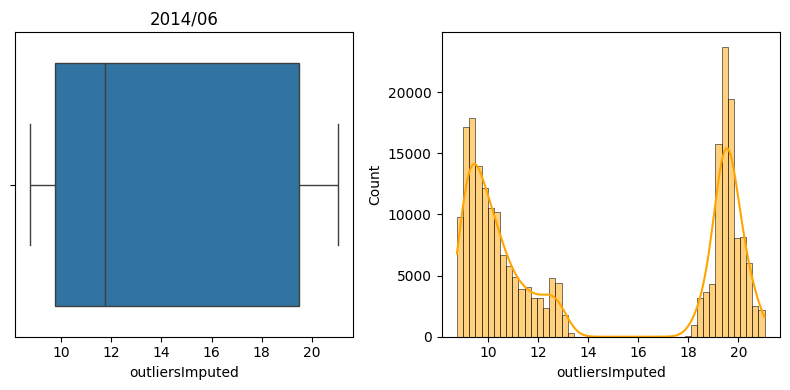

In [135]:
# Visualisation the bimodel after treating the outliers

fig, axes = plt.subplots(1, 2, figsize = (8,4))

sns.boxplot(data =Observation201406Imputed, x = 'outliersImputed', ax = axes [0])
sns.histplot(data =Observation201406Imputed, x = 'outliersImputed', bins = 50, 
             kde = True, color= 'orange', ax = axes[1])
axes[0].set_title('2014/06')
plt.tight_layout()

### Finding outliers in the bimodel By KMeans GaussianMixture 

Another method, beside the KMeans clustering, is GaussianMixture to find the outliers in a bimodel.

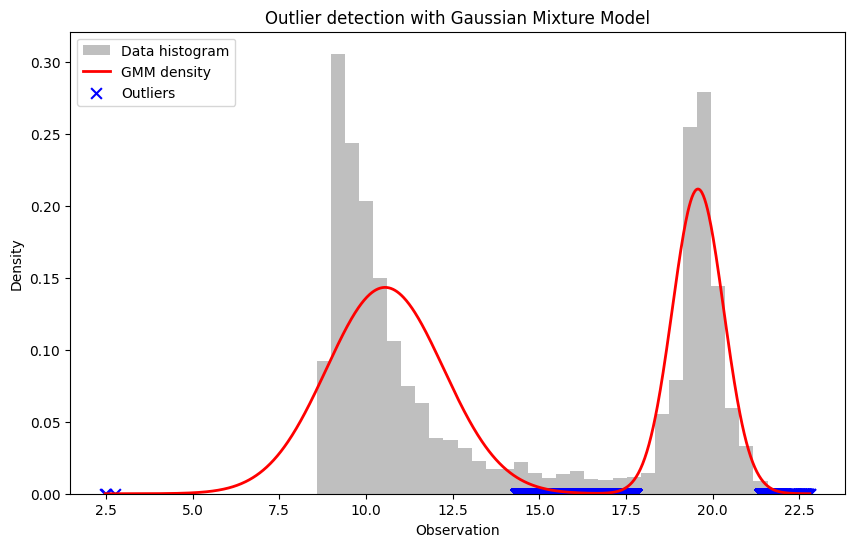

In [98]:
# Fit a Gaussian Mixture with 2 components
X = Observation201406['observation'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(X)
log_probs = gmm.score_samples(X)   # log likelihood
threshold = np.percentile(log_probs, 5)  # bottom 5% = outliers
outliers_gmm = X[log_probs < threshold]

# Plot histogram of data
plt.figure(figsize=(10,6))
plt.hist(X, bins=50, density=True, alpha=0.5, color='gray', label='Data histogram')

# Plot GMM estimated density
x_range = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
dens = np.exp(gmm.score_samples(x_range))
plt.plot(x_range, dens, color='red', lw=2, label='GMM density')

# Plot outliers
plt.scatter(outliers_gmm, np.zeros_like(outliers_gmm), 
            color='blue', marker='x', s=60, label='Outliers')

plt.xlabel('Observation')
plt.ylabel('Density')
plt.legend()
plt.title('Outlier detection with Gaussian Mixture Model')
plt.show()

## Visualisation: data distribution after treating outliers in different timestamps

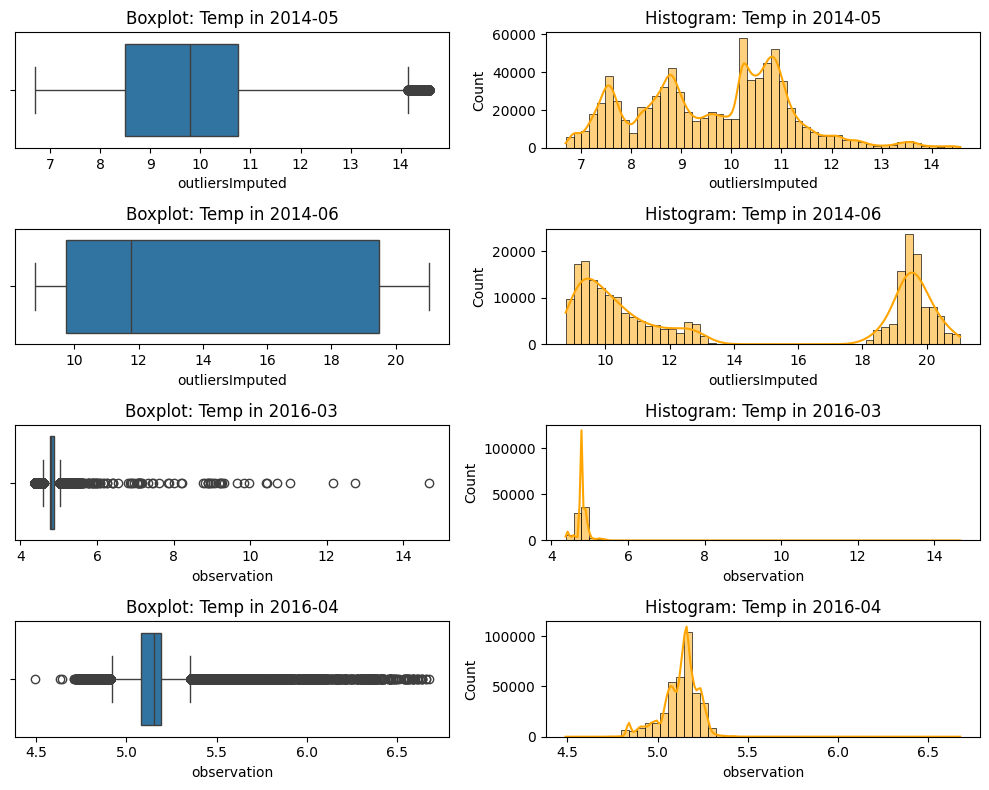

In [136]:
# Observation Histogram and Boxplot for temperature observation data after handling the outliers 

fig, axes = plt.subplots(4, 2, figsize = (10,8))

sns.boxplot(data =Observation201405, x = 'outliersImputed', ax = axes [0,0])
axes[0,0].set_title('Boxplot: Temp in 2014-05')
sns.histplot(data =Observation201405, x = 'outliersImputed', bins = 50, ax = axes [0,1], 
             kde = True, color= 'orange')
axes[0,1].set_title('Histogram: Temp in 2014-05')

sns.boxplot(data =Observation201406Imputed, x = 'outliersImputed', ax = axes [1,0])
axes[1,0].set_title('Boxplot: Temp in 2014-06')
sns.histplot(data =Observation201406Imputed, x = 'outliersImputed', bins = 50, ax = axes [1,1], 
             kde = True, color= 'orange')
axes[1,1].set_title('Histogram: Temp in 2014-06')

sns.boxplot(data =Observation201603, x = 'observation', ax = axes [2,0])
axes[2,0].set_title('Boxplot: Temp in 2016-03')
sns.histplot(data =Observation201603, x = 'observation', bins = 50, ax = axes [2,1], 
             kde = True, color= 'orange')
axes[2,1].set_title('Histogram: Temp in 2016-03')

sns.boxplot(data =Observation201604, x = 'observation', ax = axes [3,0])
axes[3,0].set_title('Boxplot: Temp in 2016-04')
sns.histplot(data =Observation201604, x = 'observation', bins = 50, ax = axes [3,1], 
             kde = True, color= 'orange')
axes[3,1].set_title('Histogram: Temp in 2016-04')

plt.tight_layout()
plt.show()

# Concatenate the imputed  datasets to build up the whole 1.5 M entry dataset

In [144]:
df1 = pd.concat([Observation201405, Observation201406Imputed])
df1 = pd.concat([Observation201405, Observation201406Imputed])
df1.rename(columns={'outliersImputed':'observation_Imputed'}, inplace = True)
df1

,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,outliers_flagged_nan,observation_Imputed,bimodel_subgroup,outliersNaN
0,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.0,temp,DEG_C,10.09,None,2014-05,10.09,10.09,NaN,NaN
1,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.5,temp,DEG_C,9.19,None,2014-05,9.19,9.19,NaN,NaN
2,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.0,temp,DEG_C,8.50,None,2014-05,8.50,8.50,NaN,NaN
3,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.5,temp,DEG_C,8.26,None,2014-05,8.26,8.26,NaN,NaN
4,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,2.0,temp,DEG_C,8.28,None,2014-05,8.28,8.28,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043850,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,16.0,temp,DEG_C,9.39,None,2014-06,NaN,9.39,1.0,9.39
1043851,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,17.0,temp,DEG_C,9.34,None,2014-06,NaN,9.34,1.0,9.34
1043852,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,18.0,temp,DEG_C,9.21,None,2014-06,NaN,9.21,1.0,9.21
1043853,EDI knb-lter-ntl.130.33,2014-06-17 04:59:00,ME,19.0,temp,DEG_C,9.02,None,2014-06,NaN,9.02,1.0,9.02


In [146]:
df2 = pd.concat([Observation201603, Observation201604])
df2.rename(columns={'observation':'observation_Imputed'}, inplace = True)
df2

,source,datetime,lake_id,depth,variable,unit,observation_Imputed,flag,year_month
1043855,EDI knb-lter-ntl.130.33,2016-03-29 15:37:00,ME,0.0,temp,DEG_C,5.88,8,2016-03
1043856,EDI knb-lter-ntl.130.33,2016-03-29 15:37:00,ME,0.5,temp,DEG_C,10.70,8,2016-03
1043857,EDI knb-lter-ntl.130.33,2016-03-29 15:37:00,ME,1.0,temp,DEG_C,12.16,8,2016-03
1043858,EDI knb-lter-ntl.130.33,2016-03-29 15:37:00,ME,1.5,temp,DEG_C,8.91,8,2016-03
1043859,EDI knb-lter-ntl.130.33,2016-03-29 15:37:00,ME,2.0,temp,DEG_C,9.65,8,2016-03
...,...,...,...,...,...,...,...,...,...
1499995,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,2.0,temp,DEG_C,5.25,None,2016-04
1499996,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,3.0,temp,DEG_C,5.25,None,2016-04
1499997,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,4.0,temp,DEG_C,5.25,None,2016-04
1499998,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,5.0,temp,DEG_C,5.26,None,2016-04


In [147]:
dfNew = pd.concat([df1, df2])
dfNew

,source,datetime,lake_id,depth,variable,unit,observation,flag,year_month,outliers_flagged_nan,observation_Imputed,bimodel_subgroup,outliersNaN
0,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.0,temp,DEG_C,10.09,None,2014-05,10.09,10.09,NaN,NaN
1,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,0.5,temp,DEG_C,9.19,None,2014-05,9.19,9.19,NaN,NaN
2,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.0,temp,DEG_C,8.50,None,2014-05,8.50,8.50,NaN,NaN
3,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,1.5,temp,DEG_C,8.26,None,2014-05,8.26,8.26,NaN,NaN
4,EDI knb-lter-ntl.130.33,2014-05-05 00:00:00,ME,2.0,temp,DEG_C,8.28,None,2014-05,8.28,8.28,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499995,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,2.0,temp,DEG_C,NaN,None,2016-04,NaN,5.25,NaN,NaN
1499996,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,3.0,temp,DEG_C,NaN,None,2016-04,NaN,5.25,NaN,NaN
1499997,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,4.0,temp,DEG_C,NaN,None,2016-04,NaN,5.25,NaN,NaN
1499998,EDI knb-lter-ntl.130.33,2016-04-12 10:10:00,ME,5.0,temp,DEG_C,NaN,None,2016-04,NaN,5.26,NaN,NaN


In [148]:
dfNew.describe()

,datetime,depth,observation,outliers_flagged_nan,observation_Imputed,bimodel_subgroup,outliersNaN
count,1500000,1.500000e+06,1.043855e+06,755008.000000,1.500000e+06,234943.000000,216956.000000
mean,2014-12-17 04:05:18.438679,9.290328e+00,1.098585e+01,9.597333,8.958764e+00,0.583175,13.945431
min,2014-05-05 00:00:00,0.000000e+00,2.050000e+00,6.690000,4.370000e+00,0.000000,8.760000
25%,2014-05-16 10:46:00,3.000000e+00,8.770000e+00,8.410000,5.200000e+00,0.000000,9.650000
50%,2014-05-27 20:50:00,9.000000e+00,1.017000e+01,9.570000,8.880000e+00,1.000000,11.180000
75%,2016-04-01 02:26:00,1.500000e+01,1.127000e+01,10.800000,1.064000e+01,1.000000,19.480000
max,2016-04-12 10:10:00,2.000000e+01,2.376000e+01,14.570000,2.105000e+01,1.000000,21.050000
std,NaN,6.290739e+00,3.508534e+00,1.548450,3.708845e+00,0.493034,4.735119


In [169]:
# Group the data based on year and month and measure the mean, min and max values of observed temperature in these times after treating the outliers

df_grouped_time = dfNew.groupby('year_month')['observation_Imputed'].agg(['mean','min','max', 'median'])
df_grouped_time

,mean,min,max,median
year_month,,,,
2014-05,9.642188,6.69,14.57,9.80
2014-06,14.149956,8.76,21.05,11.75
2016-03,4.802329,4.37,14.68,4.79
2016-04,5.128666,4.49,6.68,5.15
